In [2]:
import tensorflow as tf
from keras import __version__
tf.keras.__version__ = __version__
from imp import reload
import json
import json
import matplotlib.pyplot as plt

import time
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Embedding, Reshape
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from keras.src.saving import serialization_lib
serialization_lib.enable_unsafe_deserialization()
from tensorflow.keras.optimizers.legacy import Adam
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from rl.callbacks import TestLogger

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

from env_class_jan import BatteryManagementEnv

plt.style.use("ggplot")

In [21]:
env = BatteryManagementEnv(0)
#env.reset()

In [4]:
def build_enhanced_model(states, actions):
    # Define the input layer
    input_layer = Input(shape=(1,states))  # Adjusted for a flat input vector

    # Flatten the input if it's multidimensional
    if len(input_layer.shape) > 2:
        x = Flatten()(input_layer)
    else:
        x = input_layer

    # First hidden layer
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)  # Batch normalization layer
    x = Dropout(0.2)(x)  # Dropout layer

    x= Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Second hidden layer
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Output layer
    output = Dense(actions, activation='linear')(x)

    # Create the Keras Model
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    return model

model = build_enhanced_model(env.observation_space, env.nA)



Instructions for updating:
Colocations handled automatically by placer.


In [5]:
# Then, define DQN agent in Keras-RL
memory = SequentialMemory(limit=20000, window_length=1)
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(eps=0), 
                              attr='eps', value_max=1., value_min=.1, value_test=.05, nb_steps=10000)
dqn = DQNAgent(model=model, nb_actions=env.nA, memory=memory, policy=policy,
                nb_steps_warmup=500, target_model_update=1e-2, enable_double_dqn=True, enable_dueling_network=True)
dqn.compile(optimizer=Adam(learning_rate=1e-3), metrics=['mae'])



In [20]:
log_filename = 'results/dqn_BatteryManagementEnv_log.json'
logger = FileLogger(log_filename, interval=100)

dqn.fit(env, nb_steps=5000, visualize=False, verbose=1, nb_max_episode_steps=365, log_interval=1000,callbacks=[logger])

Training for 5000 steps ...
Interval 1 (0 steps performed)
1000/1000 [==============================] - 4s 4ms/step - reward: -8.3230
2 episodes - episode_reward: -3173.512 [-3196.410, -3150.614] - loss: 10.956 - mae: 5.901 - mean_q: 2.708 - mean_eps: 0.932

Interval 2 (1000 steps performed)
1000/1000 [==============================] - 7s 7ms/step - reward: -6.8860
3 episodes - episode_reward: -2719.287 [-2921.475, -2545.625] - loss: 8.314 - mae: 6.099 - mean_q: 2.475 - mean_eps: 0.865

Interval 3 (2000 steps performed)
1000/1000 [==============================] - 7s 7ms/step - reward: -6.6695
3 episodes - episode_reward: -2428.551 [-2621.882, -2296.335] - loss: 8.442 - mae: 6.304 - mean_q: 2.154 - mean_eps: 0.775

Interval 4 (3000 steps performed)
1000/1000 [==============================] - 7s 7ms/step - reward: -5.9718
2 episodes - episode_reward: -2045.638 [-2241.058, -1850.217] - loss: 8.184 - mae: 6.589 - mean_q: 1.830 - mean_eps: 0.685

Interval 5 (4000 steps performed)
1000/100

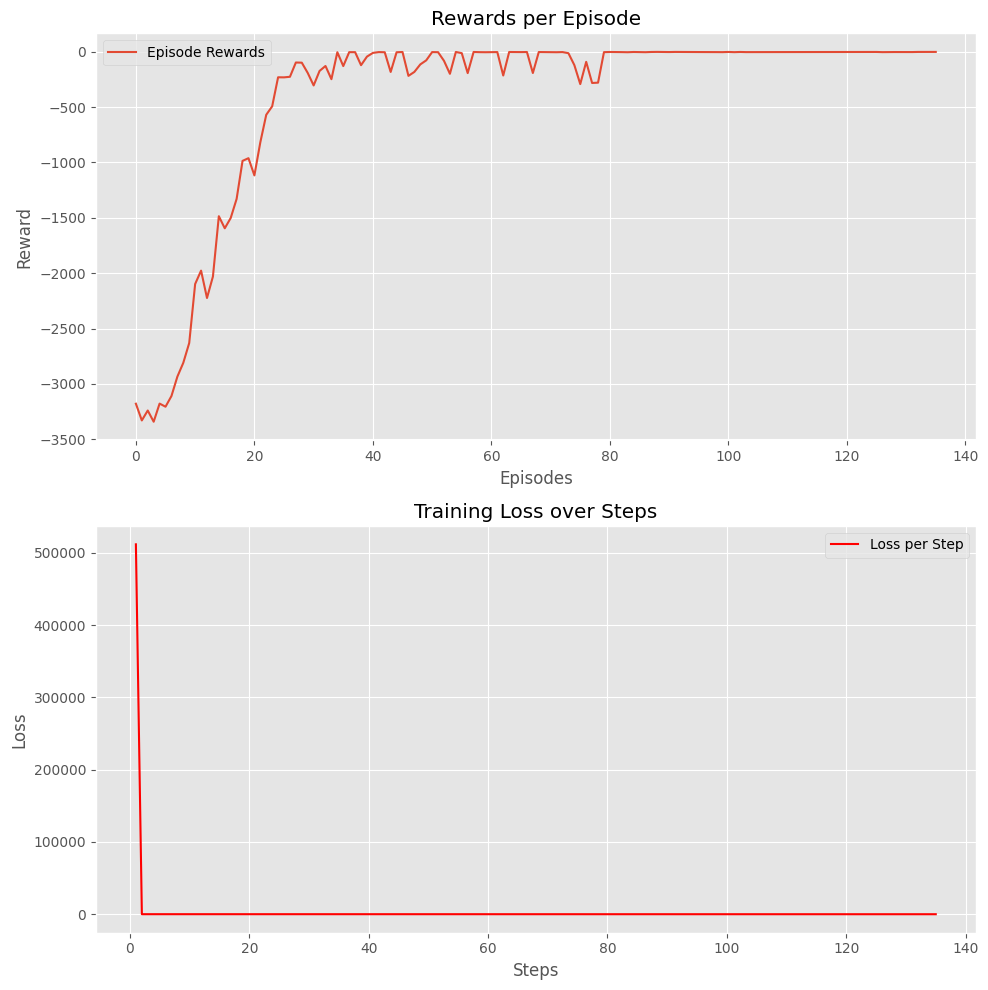

In [7]:
def plot_training_progress(log_filename):
    # Open the log file and load the data
    with open(log_filename, 'r') as file:
        data = json.load(file)
    
    # Assuming 'episode_reward' and 'loss' are keys in your logged data
    # Ensure these keys align with how you've structured your log outputs
    rewards = data.get('episode_reward', [])
    losses = data.get('loss', [])
    nb_episodes = len(rewards)
    
    # Create a plot with two subplots: one for rewards and one for losses
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    
    # Plotting the rewards
    axs[0].plot(rewards, label='Episode Rewards')
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Reward')
    axs[0].set_title('Rewards per Episode')
    axs[0].legend()
    
    # Plotting the losses, if available
    if losses:
        axs[1].plot(losses, label='Loss per Step', color='red')
        axs[1].set_xlabel('Steps')
        axs[1].set_ylabel('Loss')
        axs[1].set_title('Training Loss over Steps')
        axs[1].legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function with the path to your log file
plot_training_progress('results/dqn_BatteryManagementEnv_log.json')

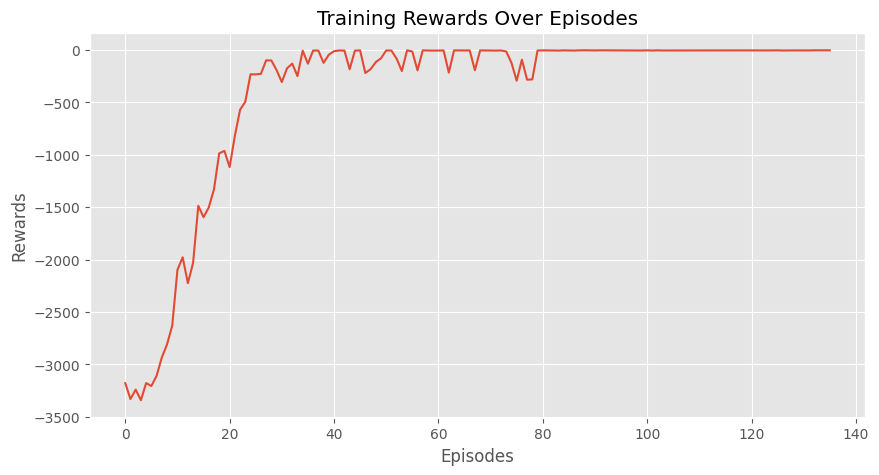

In [8]:
# def plot_rewards(log_filename):
#     with open(log_filename, 'r') as file:
#         data = json.load(file)
        
#     # Check if 'episode_rewards' is the correct key and adapt if necessary
#     if 'episode_reward' in data:
#         rewards = data['episode_reward']  # Directly use rewards if they are not nested
#         plt.figure(figsize=(10, 5))
#         plt.plot(rewards)
#         plt.title('Training Rewards Over Episodes')
#         plt.xlabel('Episodes')
#         plt.ylabel('Rewards')
#         plt.grid(True)
#         plt.show()
 
#     else:
#         print("No reward data available for plotting. Check the key names in the log file.")

# plot_rewards('results/dqn_BatteryManagementEnv_log.json')

In [10]:
# Setup testing environment
env_test = BatteryManagementEnv(0*366+24)
env_test.reset()

# Testing the model
history = dqn.test(env_test, nb_episodes=1, visualize=False,nb_max_episode_steps=365)

Testing for 1 episodes ...
Episode 1: reward: -0.167, steps: 365


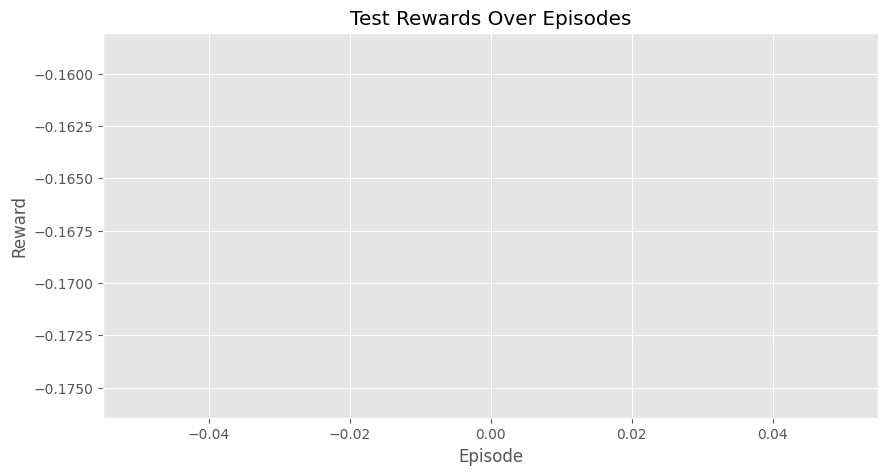

In [11]:
test_rewards = history.history['episode_reward']

def plot_test_rewards(test_rewards):
    plt.figure(figsize=(10, 5))
    plt.plot(test_rewards)
    plt.title('Test Rewards Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    plt.show()

plot_test_rewards(test_rewards)


In [16]:
def train_agent(env, agent, nb_steps, seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    env.seed(seed)
    
    log_filename = f'dqn_BatteryManagementEnv_seed_{seed}_log.json'
    logger = FileLogger(log_filename, interval=100)

    agent.fit(env, nb_steps=nb_steps, visualize=False, verbose=1, nb_max_episode_steps=365, log_interval=365, callbacks=[logger])

    return log_filename

In [17]:
seeds = [42, 43, 44, 45]  # Example seeds
log_filenames = [train_agent(env, dqn, 1000, seed) for seed in seeds]

Training for 1000 steps ...
Interval 1 (0 steps performed)
1000/1000 [==============================] - 4s 4ms/step - reward: -8.4206
done, took 4.017 seconds
Training for 1000 steps ...
Interval 1 (0 steps performed)
1000/1000 [==============================] - 4s 4ms/step - reward: -8.3334
done, took 4.031 seconds
Training for 1000 steps ...
Interval 1 (0 steps performed)
1000/1000 [==============================] - 4s 4ms/step - reward: -7.8648
done, took 4.093 seconds
Training for 1000 steps ...
Interval 1 (0 steps performed)
1000/1000 [==============================] - 4s 4ms/step - reward: -8.4494
done, took 3.752 seconds


In [18]:
def aggregate_rewards(log_filenames):
    all_rewards = []

    # Load all reward data
    for filename in log_filenames:
        with open(filename, 'r') as file:
            data = json.load(file)
            all_rewards.append(data['episode_reward'])  # Assuming each file contains 'episode_reward'
    
    # Calculate mean and standard deviation
    
    reward_array = np.array(all_rewards)  # Shape: (num_seeds, num_episodes)
    mean_rewards = np.mean(reward_array, axis=0)
    std_rewards = np.std(reward_array, axis=0)

    return mean_rewards, std_rewards

mean_rewards, std_rewards = aggregate_rewards(log_filenames)


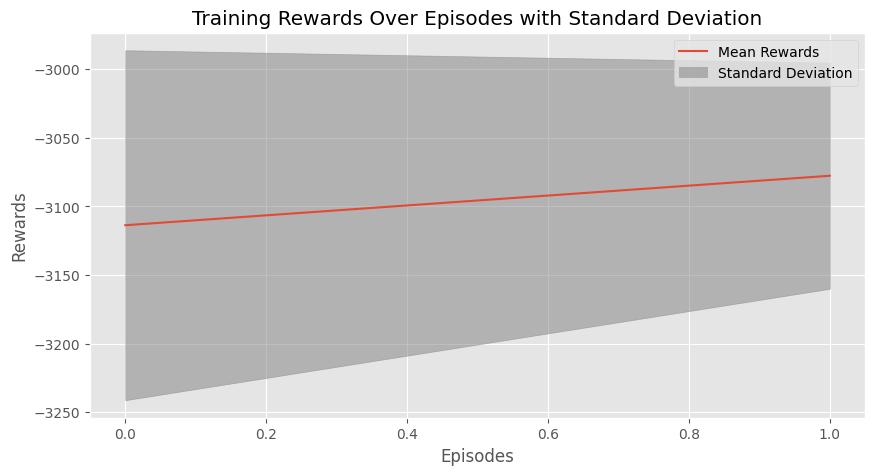

In [19]:
def plot_rewards_with_std(mean_rewards, std_rewards):
    episodes = np.arange(len(mean_rewards))
    plt.figure(figsize=(10, 5))
    plt.plot(episodes, mean_rewards, label='Mean Rewards')
    plt.fill_between(episodes, mean_rewards - std_rewards, mean_rewards + std_rewards, color='gray', alpha=0.5, label='Standard Deviation')
    plt.title('Training Rewards Over Episodes with Standard Deviation')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rewards_with_std(mean_rewards, std_rewards)
